---
# Loading Libraries
---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as prog_bar

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout


---
### Encoding and Scaling data
---

In [5]:
cg = ('a','b','c','d')
OHEs = {}
Scalers = {}
for x in cg:
    Scalers[x] = StandardScaler()
    OHEs[x] = OneHotEncoder()

In [6]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Simple_Train_Test_Data_Splits')
TTS_FILE_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_FILE_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['simple@TTS_test_50_50.csv', 'simple@TTS_test_60_40.csv', 'simple@TTS_test_75_25.csv', 'simple@TTS_test_80_20.csv', 'simple@TTS_train_50_50.csv', 'simple@TTS_train_60_40.csv', 'simple@TTS_train_75_25.csv', 'simple@TTS_train_80_20.csv']


---
## X Trains-Test & Y Train-Tests loaded
---

In [7]:
x_trains = {}
y_trains= {}
x_tests = {}
y_tests = {}

for tts_file in prog_bar(TTS_FILE_LIST,total = len(TTS_FILE_LIST)):
    tts_file_path = os.path.join(TTS_BASE_DIR,tts_file)
    df = pd.read_csv(tts_file_path,index_col=False)
    tts_file_wo_ext = tts_file.split('.')[0].split('_')
    k = TTS_DICT_INV[tts_file_wo_ext[-1]]
    if 'train' in tts_file_wo_ext:
        #depend on test set size
        x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
        x_trains[k] = np.expand_dims(x_trains[k], axis=2)
        y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
    else:
        x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
        x_tests[k] = np.expand_dims(x_tests[k], axis=2)
        y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
     
        

  0%|          | 0/8 [00:00<?, ?it/s]

# Model Development 
---

#### Modle save location
----

In [8]:
MODEL_BASE_DIR = os.path.abspath('Models')

---
## Accuracy testing function
---

In [13]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()


---
# Model 1
---

In [9]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_1'))

> main model-1 function

> - simple model 

> - acc : X %

In [10]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

#### making 4 copies of simple model 1 to train on different train-test split
---
 

In [11]:
Model_1_dict = {}
for k in cg:
    Model_1_dict[k] = model_1(x_trains[k])

----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [14]:
Simple_History_1 = {}
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 40

In [15]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Simple_History_1[k] = Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_1_dict[k].save(os.path.join("Models",'simple@model_1',f"simple@model_1_{'_'.join(TTS_DICT[k])}.h5"))

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
9/9 [==============================] - 1s 67ms/step - loss: 2.0276 - accuracy: 0.1981 - val_loss: 1.8457 - val_accuracy: 0.2278
Epoch 2/40
9/9 [==============================] - 1s 64ms/step - loss: 1.8648 - accuracy: 0.2556 - val_loss: 1.8315 - val_accuracy: 0.2667
Epoch 3/40
9/9 [==============================] - 1s 70ms/step - loss: 1.8000 - accuracy: 0.3000 - val_loss: 1.7725 - val_accuracy: 0.3333
Epoch 4/40
9/9 [==============================] - 1s 60ms/step - loss: 1.7643 - accuracy: 0.3204 - val_loss: 1.7637 - val_accuracy: 0.3222
Epoch 5/40
9/9 [==============================] - 1s 66ms/step - loss: 1.6868 - accuracy: 0.3648 - val_loss: 1.7540 - val_accuracy: 0.3556
Epoch 6/40
9/9 [==============================] - 1s 65ms/step - loss: 1.6585 - accuracy: 0.3759 - val_loss: 1.7215 - val_accuracy: 0.3778
Epoch

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
23/23 [==============================] - 0s 6ms/step - loss: 1.5275 - accuracy: 0.4542
Accuracy of our model on test data :  45.41666805744171 %


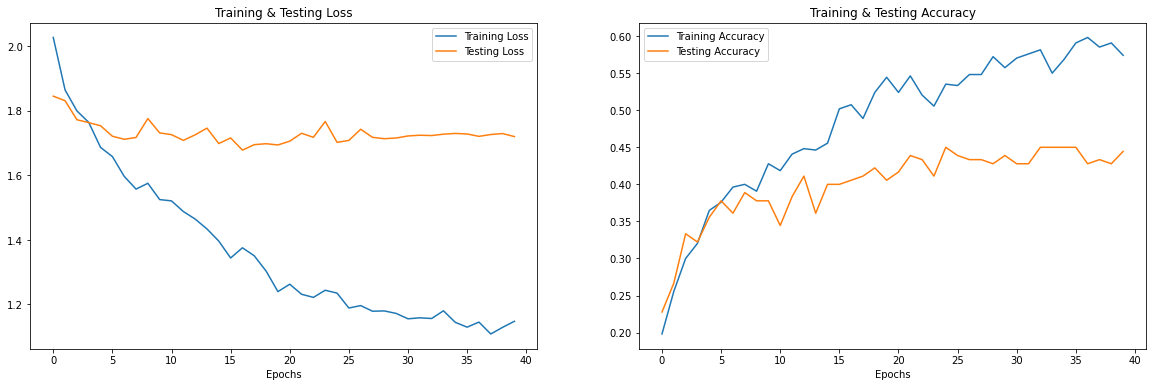

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
18/18 [==============================] - 0s 6ms/step - loss: 1.4510 - accuracy: 0.4774
Accuracy of our model on test data :  47.74305522441864 %


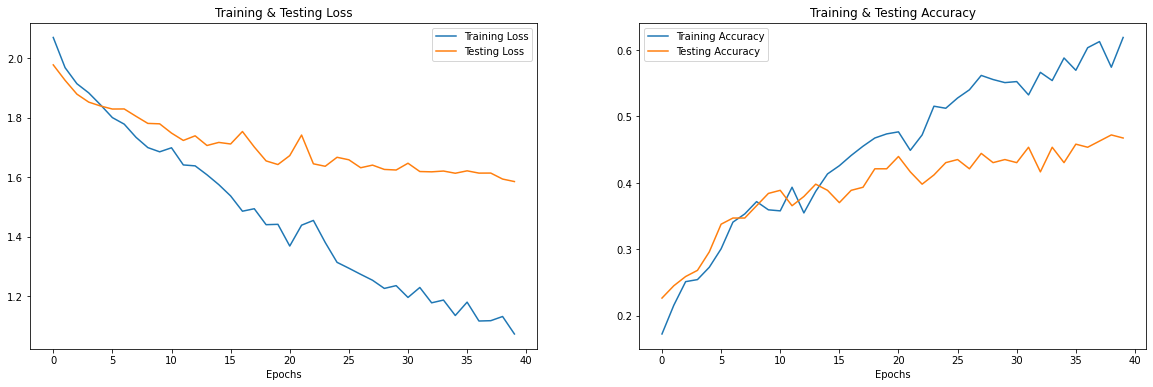

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
12/12 [==============================] - 0s 6ms/step - loss: 1.5103 - accuracy: 0.4944
Accuracy of our model on test data :  49.44444298744202 %


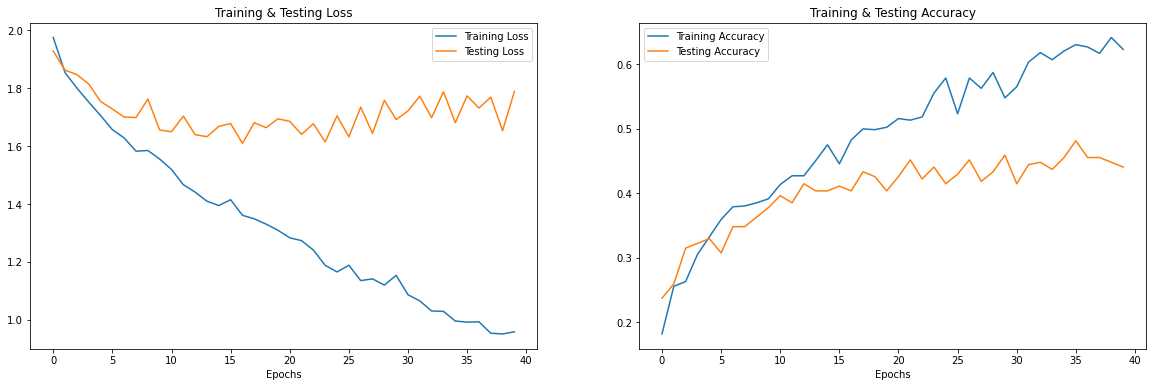

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
9/9 [==============================] - 0s 5ms/step - loss: 1.4890 - accuracy: 0.5000
Accuracy of our model on test data :  50.0 %


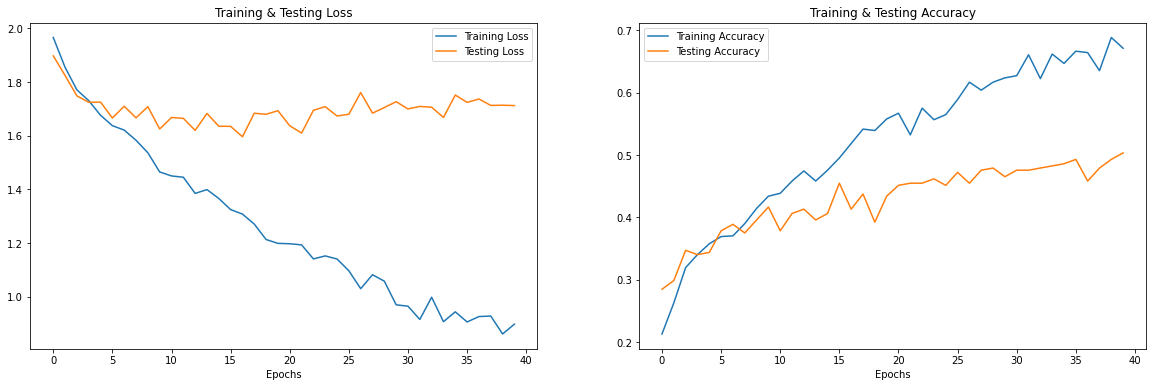

In [16]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_1_dict[k],Simple_History_1[k],epoch,x_tests[k],y_tests[k])

## Model 2
----

In [17]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_2')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_2'))

In [18]:
def model_2(x_train):
    model=Sequential()
    model.add(Conv1D(128, kernel_size=7, strides=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 2, padding = 'same'))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [22]:
Model_2_dict = {}
for k in cg:
    Model_2_dict[k] = model_2(x_trains[k])

In [20]:
Simple_History_2 = {}
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 40

In [23]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Traing is done for Model 2")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Simple_History_2[k] = Model_2_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_2_dict[k].save(os.path.join("Models",'simple@model_2',f"simple@model_2_{'_'.join(TTS_DICT[k])}.h5"))

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
9/9 [==============================] - 1s 44ms/step - loss: 2.0348 - accuracy: 0.2056 - val_loss: 1.9097 - val_accuracy: 0.2278
Epoch 2/40
9/9 [==============================] - 0s 20ms/step - loss: 1.9405 - accuracy: 0.2185 - val_loss: 1.8883 - val_accuracy: 0.2444
Epoch 3/40
9/9 [==============================] - 0s 25ms/step - loss: 1.8891 - accuracy: 0.2667 - val_loss: 1.8608 - val_accuracy: 0.2444
Epoch 4/40
9/9 [==============================] - 0s 20ms/step - loss: 1.8721 - accuracy: 0.2685 - val_loss: 1.8529 - val_accuracy: 0.2833
Epoch 5/40
9/9 [==============================] - 0s 21ms/step - loss: 1.8190 - accuracy: 0.3167 - val_loss: 1.8211 - val_accuracy: 0.3000
Epoch 6/40
9/9 [==============================] - 0s 26ms/step - loss: 1.7951 - accuracy: 0.3352 - val_loss: 1.8147 - val_accuracy: 0.3167
Epoch

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Testing is going on for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
23/23 [==============================] - 0s 2ms/step - loss: 1.6599 - accuracy: 0.4681
Accuracy of our model on test data :  46.80555462837219 %


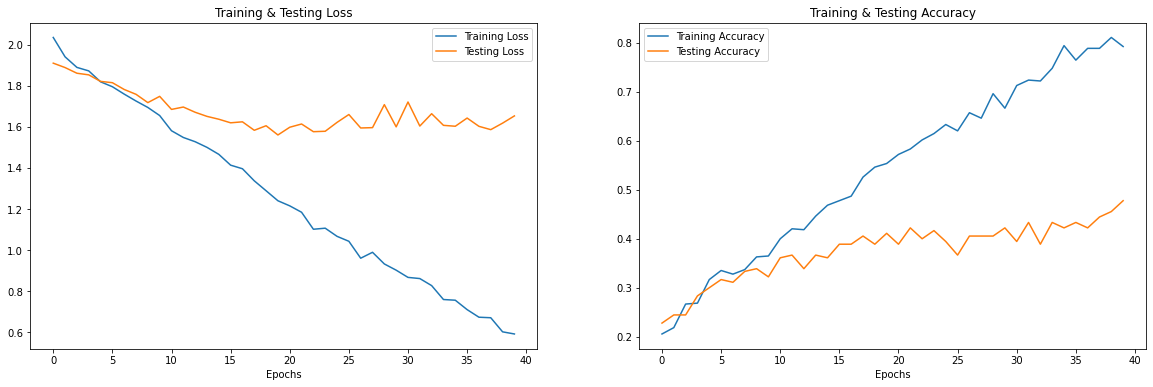

-------------------
Testing is going on for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
18/18 [==============================] - 0s 2ms/step - loss: 1.3464 - accuracy: 0.5312
Accuracy of our model on test data :  53.125 %


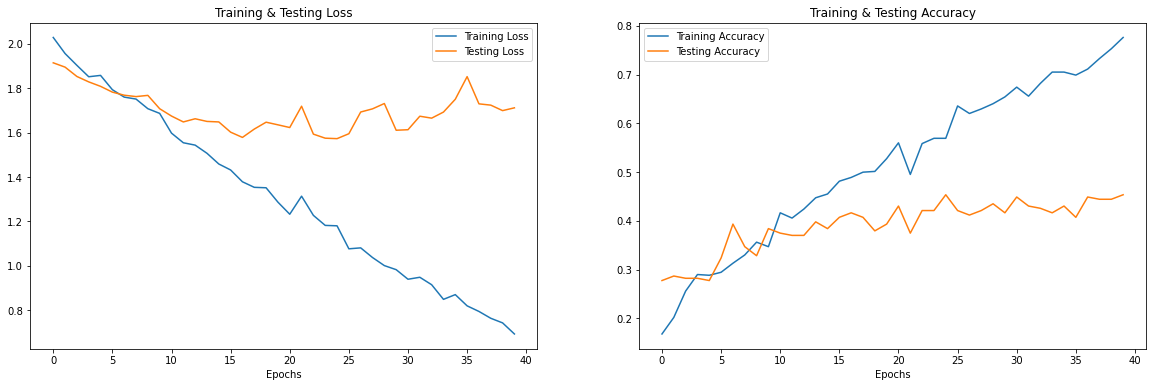

-------------------
Testing is going on for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
12/12 [==============================] - 0s 2ms/step - loss: 1.3992 - accuracy: 0.5333
Accuracy of our model on test data :  53.33333611488342 %


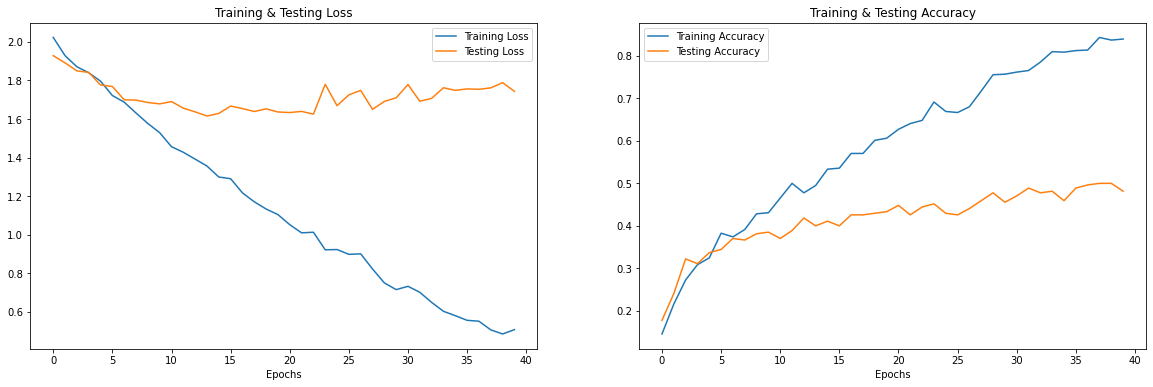

-------------------
Testing is going on for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
9/9 [==============================] - 0s 2ms/step - loss: 1.4969 - accuracy: 0.5521
Accuracy of our model on test data :  55.20833134651184 %


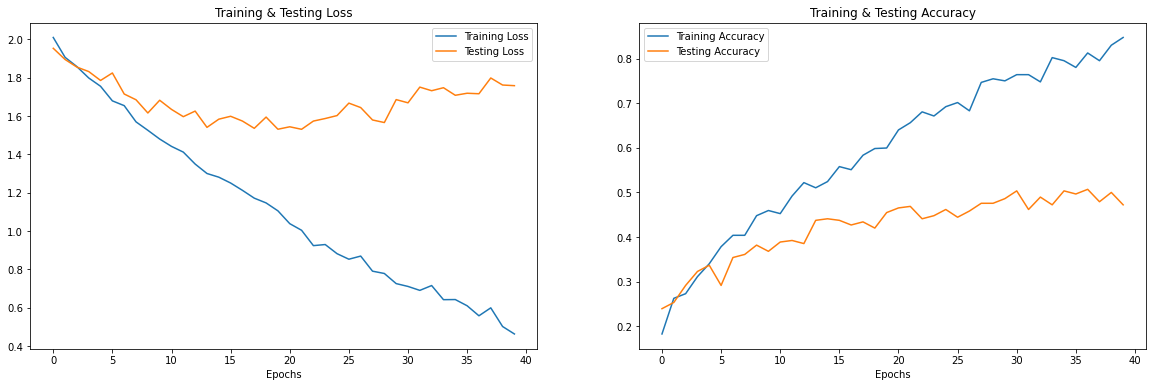

In [24]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Testing is going on for Model 2")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_2_dict[k],Simple_History_2[k],epoch,x_tests[k],y_tests[k])

## Model 3
----

In [25]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_3')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_3'))

In [26]:
def model_3(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 3, padding = 'same'))

    model.add(Conv1D(256, kernel_size=9, strides=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 5, padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [27]:
Model_3_dict = {}
for k in cg:
    Model_3_dict[k] = model_3(x_trains[k])
Simple_History_3 = {}
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 40

In [28]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Traing is done for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Simple_History_3[k] = Model_3_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_3_dict[k].save(os.path.join("Models",'simple@model_3',f"simple@model_3_{'_'.join(TTS_DICT[k])}.h5"))


  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
9/9 [==============================] - 1s 82ms/step - loss: 1.9879 - accuracy: 0.1981 - val_loss: 1.9264 - val_accuracy: 0.1944
Epoch 2/40
9/9 [==============================] - 0s 40ms/step - loss: 1.9112 - accuracy: 0.2815 - val_loss: 1.8353 - val_accuracy: 0.2667
Epoch 3/40
9/9 [==============================] - 0s 33ms/step - loss: 1.8427 - accuracy: 0.2741 - val_loss: 1.8302 - val_accuracy: 0.2833
Epoch 4/40
9/9 [==============================] - 0s 34ms/step - loss: 1.8032 - accuracy: 0.3037 - val_loss: 1.7952 - val_accuracy: 0.3333
Epoch 5/40
9/9 [==============================] - 0s 34ms/step - loss: 1.7493 - accuracy: 0.3389 - val_loss: 1.7748 - val_accuracy: 0.3500
Epoch 6/40
9/9 [==============================] - 0s 33ms/step - loss: 1.6935 - accuracy: 0.3815 - val_loss: 1.7445 - val_accuracy: 0.3722
Epoch

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------
Testing is going on for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
23/23 [==============================] - 0s 8ms/step - loss: 1.6510 - accuracy: 0.5222
Accuracy of our model on test data :  52.222222089767456 %


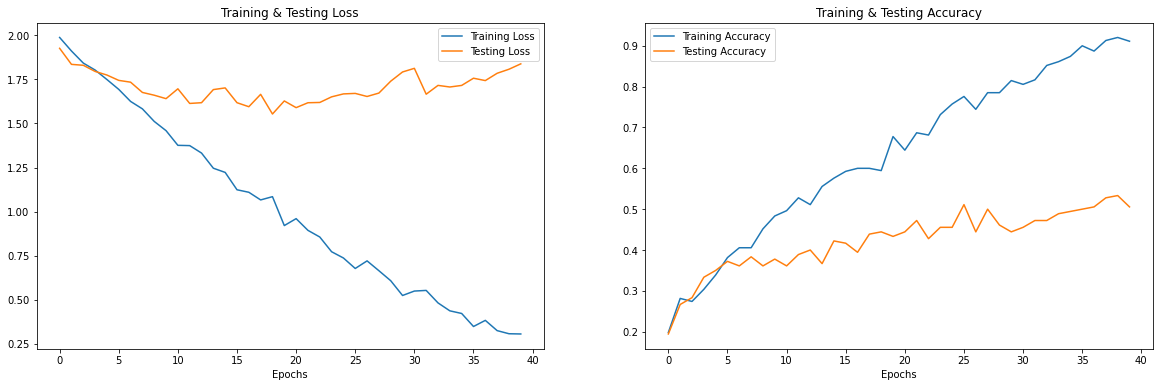

-------------------
Testing is going on for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
18/18 [==============================] - 0s 5ms/step - loss: 1.4526 - accuracy: 0.5694
Accuracy of our model on test data :  56.94444179534912 %


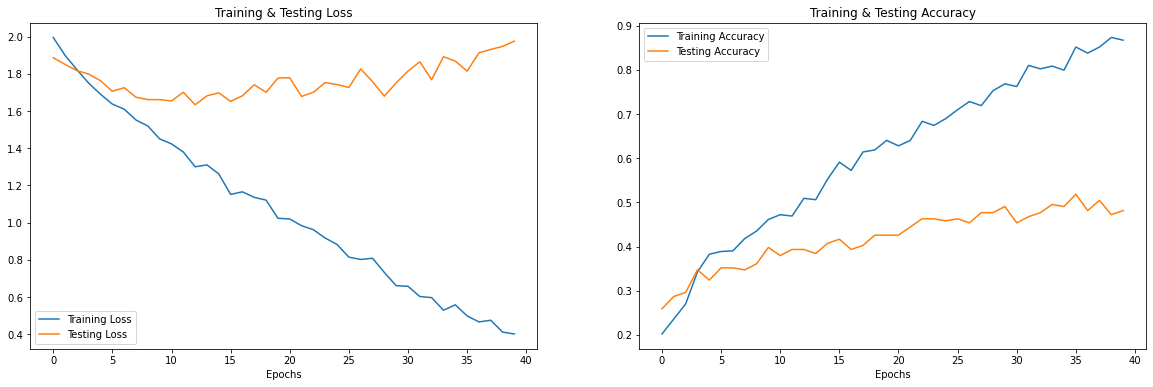

-------------------
Testing is going on for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
12/12 [==============================] - 0s 6ms/step - loss: 1.7738 - accuracy: 0.5722
Accuracy of our model on test data :  57.22222328186035 %


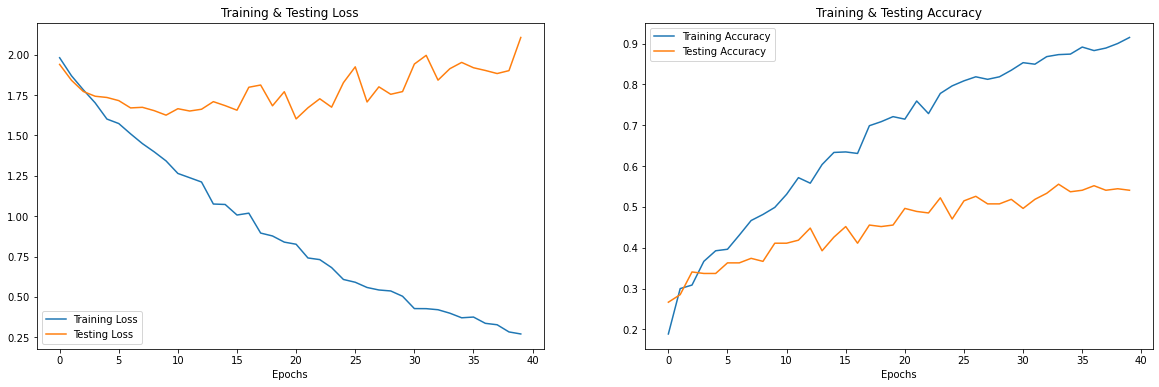

-------------------
Testing is going on for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
9/9 [==============================] - 0s 8ms/step - loss: 1.8150 - accuracy: 0.5764
Accuracy of our model on test data :  57.63888955116272 %


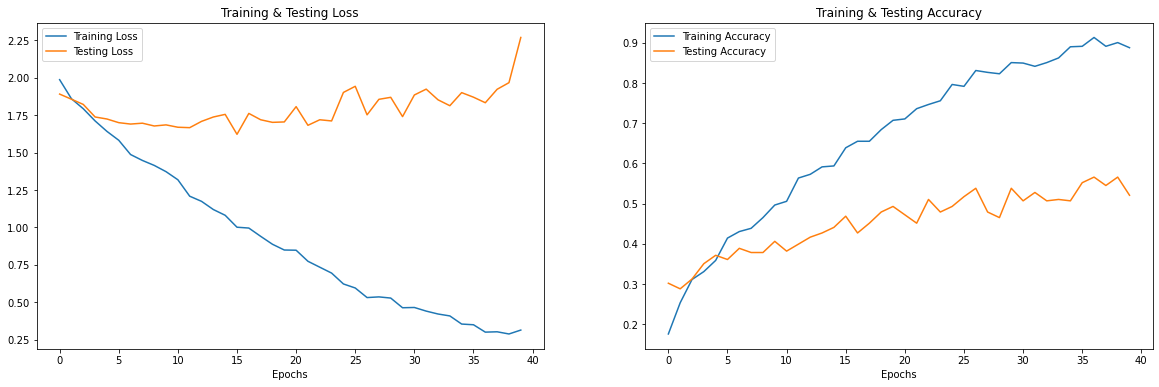

In [29]:
for k in prog_bar(cg,total=4):
    print("-------------------")
    print(f"Testing is going on for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_3_dict[k],Simple_History_3[k],epoch,x_tests[k],y_tests[k])